In [1]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                    level=logging.INFO, stream=sys.stdout)

# import matplotlib as mpl
# mpl.use('pgf')  # Enable for pgf backend
from dsm_swap import rh_knitter, linear_decay, dag_decompose 
from dsm_swap import plot_circ

import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.converters import circuit_to_dag, dag_to_circuit
from functools import partial
%matplotlib inline

## DSM-SWAP Demo

In [2]:
# Configurations

seed = 38492314298

# Number of repetitions of the pattern of swaps (depends of topology).
swap_layers = 'log_2'

# The maximum number of layers considered on each step.
horizon = 2

# Number of restarts for the optimiser at each step.
restarts = 5

# Layout pass for emulating the transpilation process.
run_layout_pass = 1

dump_file = None

In [3]:
#  Prepare the input quantum circuit.
import gzip
from qiskit.circuit import qpy_serialization
with gzip.open('../stats/nannicini-qv8/qv256_batch1_original.qpy.gz', 'rb') as f:
    circuits_orig1 = qpy_serialization.load(f)
    qc = circuits_orig1[2]
    circuits_orig1 = None

In [4]:
# Other possible options for the input circuit.

# from qiskit.circuit.library import QuantumVolume
# qc = QuantumVolume(10).decompose()

# from qiskit.quantum_info import random_clifford
# qc = random_clifford(8, seed=1).to_circuit()

# MCX test. Use line connectivity
# from qiskit import QuantumCircuit
# horizon = 8
# qc = QuantumCircuit(5)
# qc.mcx(list(range(qc.num_qubits - 1)), qc.num_qubits - 1)
# qc = qc.decompose().decompose()

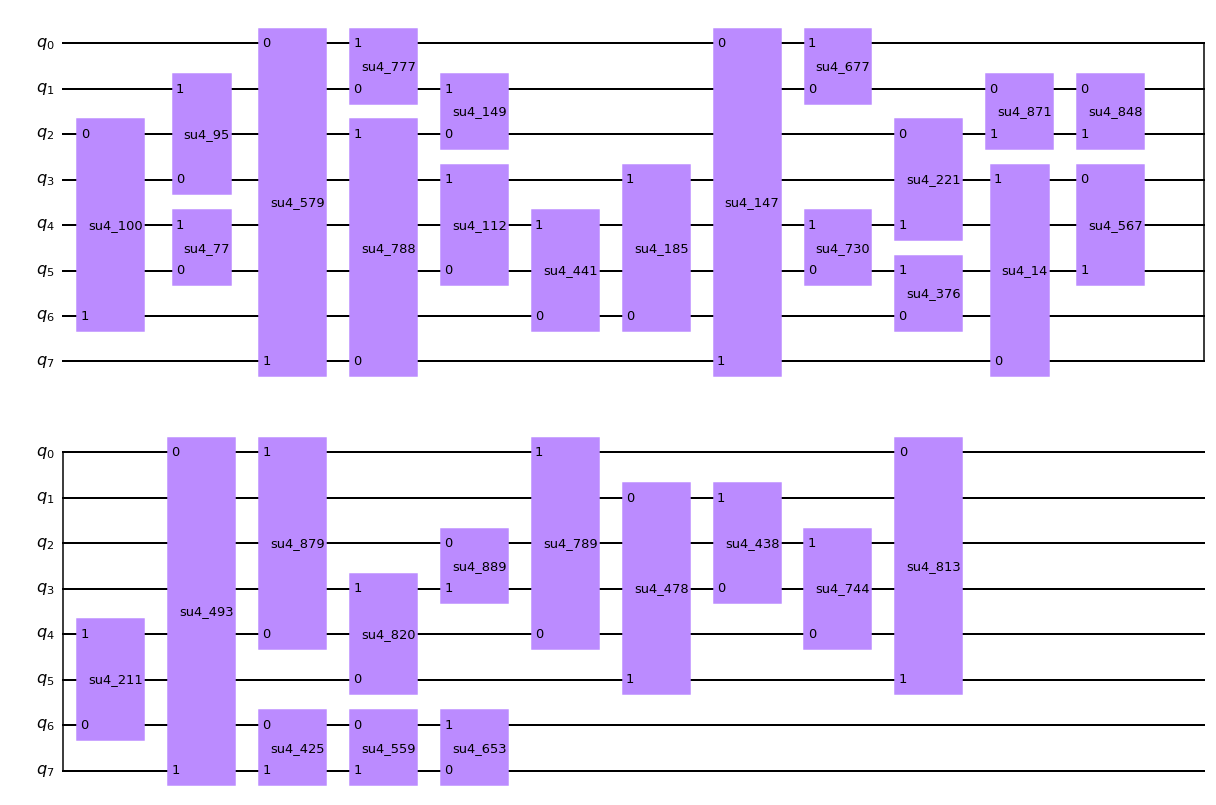

In [5]:
# Plot the input circuit.
qc.draw('mpl')

In [6]:
# Apply the layout pass.

from qiskit.transpiler.passes.layout.apply_layout import ApplyLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout

# cmap = CouplingMap.from_line(qc.num_qubits, bidirectional=True)
cmap = CouplingMap.from_ring(qc.num_qubits, bidirectional=True)
# cmap = CouplingMap.from_grid(5, 2)

layout = SabreLayout(cmap, max_iterations=3, seed=seed)
dag = circuit_to_dag(qc)
layout.run(dag)

apply_layout = ApplyLayout()
apply_layout.property_set['layout'] = layout.property_set['layout']
if run_layout_pass:
    dag = apply_layout.run(dag)

2022-09-29 11:56:51,692 | INFO : Pass: SetLayout - 0.00000 (ms)
2022-09-29 11:56:51,695 | INFO : Pass: FullAncillaAllocation - 0.00000 (ms)
2022-09-29 11:56:51,696 | INFO : Pass: EnlargeWithAncilla - 0.00000 (ms)
2022-09-29 11:56:51,698 | INFO : Pass: ApplyLayout - 0.99349 (ms)
2022-09-29 11:56:51,709 | INFO : Pass: SabreSwap - 9.01031 (ms)
2022-09-29 11:56:51,712 | INFO : Pass: SetLayout - 0.00000 (ms)
2022-09-29 11:56:51,715 | INFO : Pass: FullAncillaAllocation - 0.00000 (ms)
2022-09-29 11:56:51,716 | INFO : Pass: EnlargeWithAncilla - 0.00000 (ms)
2022-09-29 11:56:51,717 | INFO : Pass: ApplyLayout - 0.99754 (ms)
2022-09-29 11:56:51,725 | INFO : Pass: SabreSwap - 7.01618 (ms)
2022-09-29 11:56:51,727 | INFO : new initial layout
2022-09-29 11:56:51,727 | INFO : Layout({
0: Qubit(QuantumRegister(8, 'q'), 0),
4: Qubit(QuantumRegister(8, 'q'), 1),
2: Qubit(QuantumRegister(8, 'q'), 2),
5: Qubit(QuantumRegister(8, 'q'), 3),
7: Qubit(QuantumRegister(8, 'q'), 4),
6: Qubit(QuantumRegister(8, 'q

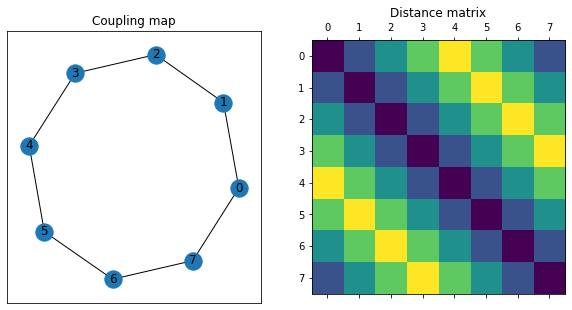

In [7]:
# Plot the coupling map and the corresponding distance matrix.

cmapg = nx.Graph()
cmapg.add_edges_from(cmap.get_edges())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
nx.draw_networkx(cmapg, ax=axs[0])
axs[0].set_title('Coupling map')
axs[1].matshow(cmap.distance_matrix)
axs[1].set_title('Distance matrix')
plt.show()

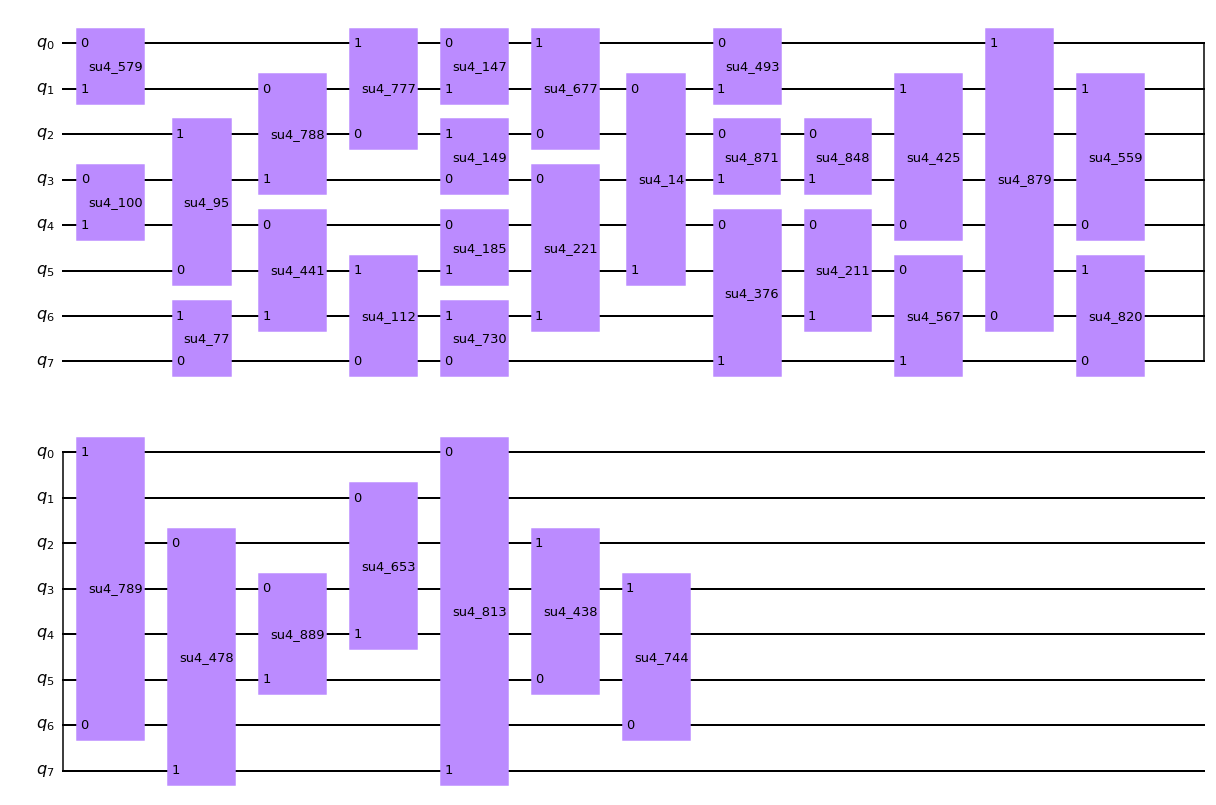

In [8]:
# Plot the input circuit after the layout pass.

dag_to_circuit(dag).draw('mpl')

In [9]:
# Run the DSM-SWAP algorithm.

dagd = dag_decompose(dag)   # Decompose the circuit into layers of commuting 2-qubit gates.
circ_adjs = dagd.get_adjs(mode='coo')   # Transform the layers into adjacency matrices.

# Run the Rolling Horizon Knitter.
layer_perms = rh_knitter(circ_adjs, max_optim_steps=30, seed=seed,
                         horizon=horizon,
                         restart=restarts,
                         cmap=cmap, hw_cost_decay=linear_decay,
                         swap_layers=swap_layers)

2022-09-29 11:56:52,783 | INFO : Loop restart, frame_start=0
2022-09-29 11:56:57,121 | INFO : Optim completed, hw_cost=2.2947657271288335e-05, swap_cost=8.631825809679583e-10
2022-09-29 11:56:57,264 | INFO : Knitter stats: {'param_count': 48, 'swap_layers': 3, 'optim_steps': 26}
2022-09-29 11:56:57,267 | INFO : Loop restart, frame_start=2
2022-09-29 11:57:01,990 | INFO : Optim completed, hw_cost=0.04253515601158142, swap_cost=4.701908111572266
2022-09-29 11:57:02,107 | INFO : Knitter stats: {'param_count': 48, 'swap_layers': 3, 'optim_steps': 25}
2022-09-29 11:57:07,006 | INFO : Optim completed, hw_cost=0.044553957879543304, swap_cost=4.694979190826416
2022-09-29 11:57:11,895 | INFO : Optim completed, hw_cost=0.041285548359155655, swap_cost=4.706365585327148
2022-09-29 11:57:18,363 | INFO : Optim completed, hw_cost=0.03940480202436447, swap_cost=4.712873458862305
2022-09-29 11:57:23,315 | INFO : Optim completed, hw_cost=0.03592154383659363, swap_cost=4.725672245025635
2022-09-29 11:57:

In [10]:
# Average layer density for the input circuit.
dagd.avg_layer_density()

1.0

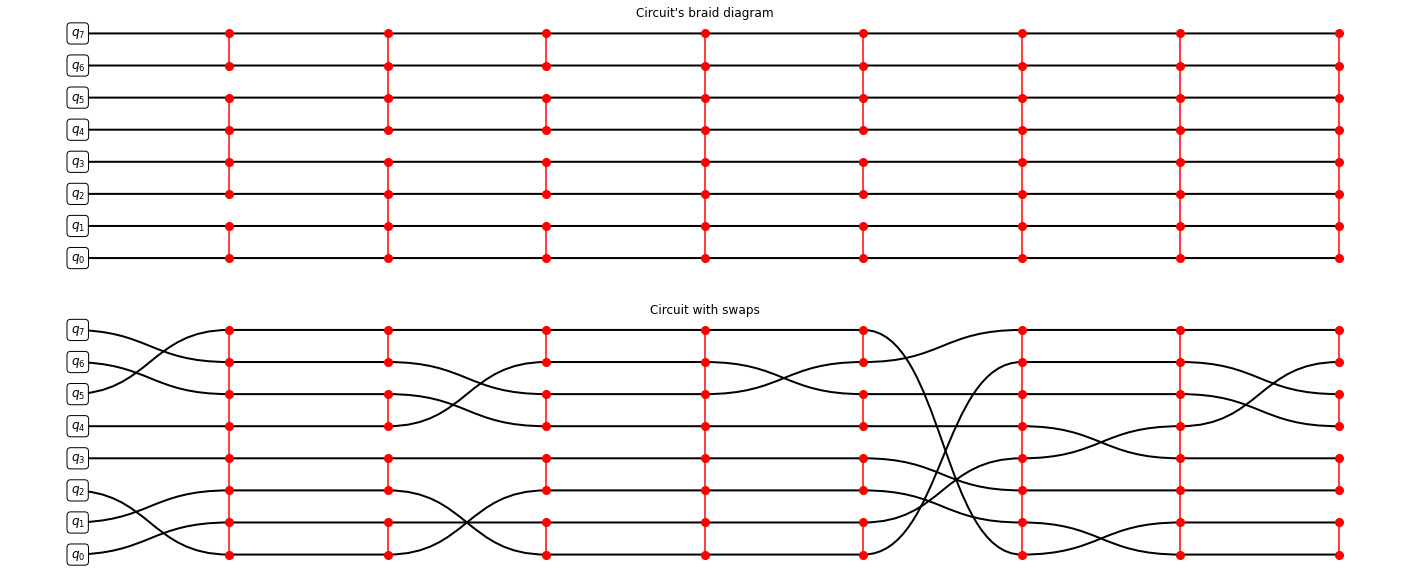

In [11]:
# Plot of the input (after layout pass) and the resulting circuit using the braid visualization.

fig, axs = plt.subplots(2, 1, figsize=(25, 10), facecolor='white')
from dsm_swap.math import reduce_level_np_matmul
layer_perms1 = reduce_level_np_matmul(layer_perms, 1)
plot_circ(perms=[np.eye(*p.shape) for p in layer_perms1], adjs_coo=circ_adjs, ax=axs[0])
plot_circ(perms=layer_perms1, adjs_coo=circ_adjs, ax=axs[1])
axs[0].set_title('Circuit\'s braid diagram')
axs[1].set_title('Circuit with swaps')
plt.show()
# plt.savefig('braid1.pgf', format='pgf')

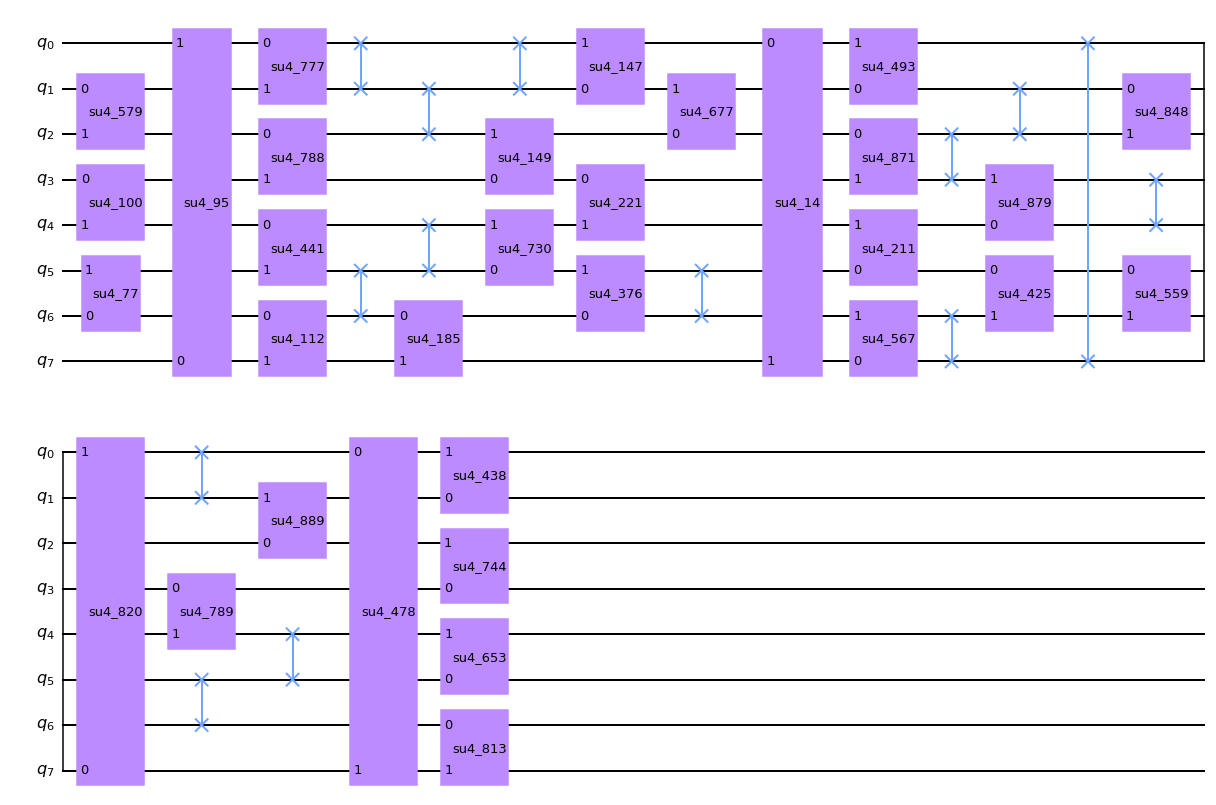

In [12]:
# *** Final circuit ***

qc3, final_layout = dagd.compose(layer_perms)
qc3 = dag_to_circuit(qc3)
qc3.draw('mpl')

In [13]:
# The final layout.

final_layout

Layout({
0: Qubit(QuantumRegister(8, 'q'), 6),
1: Qubit(QuantumRegister(8, 'q'), 5),
2: Qubit(QuantumRegister(8, 'q'), 0),
3: Qubit(QuantumRegister(8, 'q'), 2),
4: Qubit(QuantumRegister(8, 'q'), 4),
5: Qubit(QuantumRegister(8, 'q'), 1),
6: Qubit(QuantumRegister(8, 'q'), 3),
7: Qubit(QuantumRegister(8, 'q'), 7)
})

In [14]:
# Circuit statistics for DSM-SWAP after a compiling with level 3 optimization.

transpile(qc3, basis_gates=['u3', 'cx'], optimization_level=3).count_ops()

2022-09-29 11:58:21,165 | INFO : Pass: UnitarySynthesis - 0.00000 (ms)
2022-09-29 11:58:21,165 | INFO : Pass: Unroll3qOrMore - 0.00000 (ms)
2022-09-29 11:58:21,166 | INFO : Pass: RemoveResetInZeroState - 0.00000 (ms)
2022-09-29 11:58:21,167 | INFO : Pass: OptimizeSwapBeforeMeasure - 0.00000 (ms)
2022-09-29 11:58:21,167 | INFO : Pass: RemoveDiagonalGatesBeforeMeasure - 0.00000 (ms)
2022-09-29 11:58:21,384 | INFO : Pass: UnitarySynthesis - 216.45355 (ms)
2022-09-29 11:58:21,386 | INFO : Pass: UnrollCustomDefinitions - 0.95987 (ms)
2022-09-29 11:58:21,388 | INFO : Begin BasisTranslator from source basis {('cx', 2), ('u3', 1), ('swap', 2)} to target basis {'snapshot', 'delay', 'reset', 'cx', 'u3', 'measure', 'barrier'}.
2022-09-29 11:58:21,390 | INFO : Basis translation path search completed in 0.002s.
2022-09-29 11:58:21,393 | INFO : Basis translation paths composed in 0.002s.
2022-09-29 11:58:21,396 | INFO : Basis translation instructions replaced in 0.003s.
2022-09-29 11:58:21,396 | INF

OrderedDict([('u3', 194), ('cx', 99)])

In [15]:
if dump_file is not None:
    with open(dump_file, 'wb') as fd:
        qpy_serialization.dump(qc3, fd)

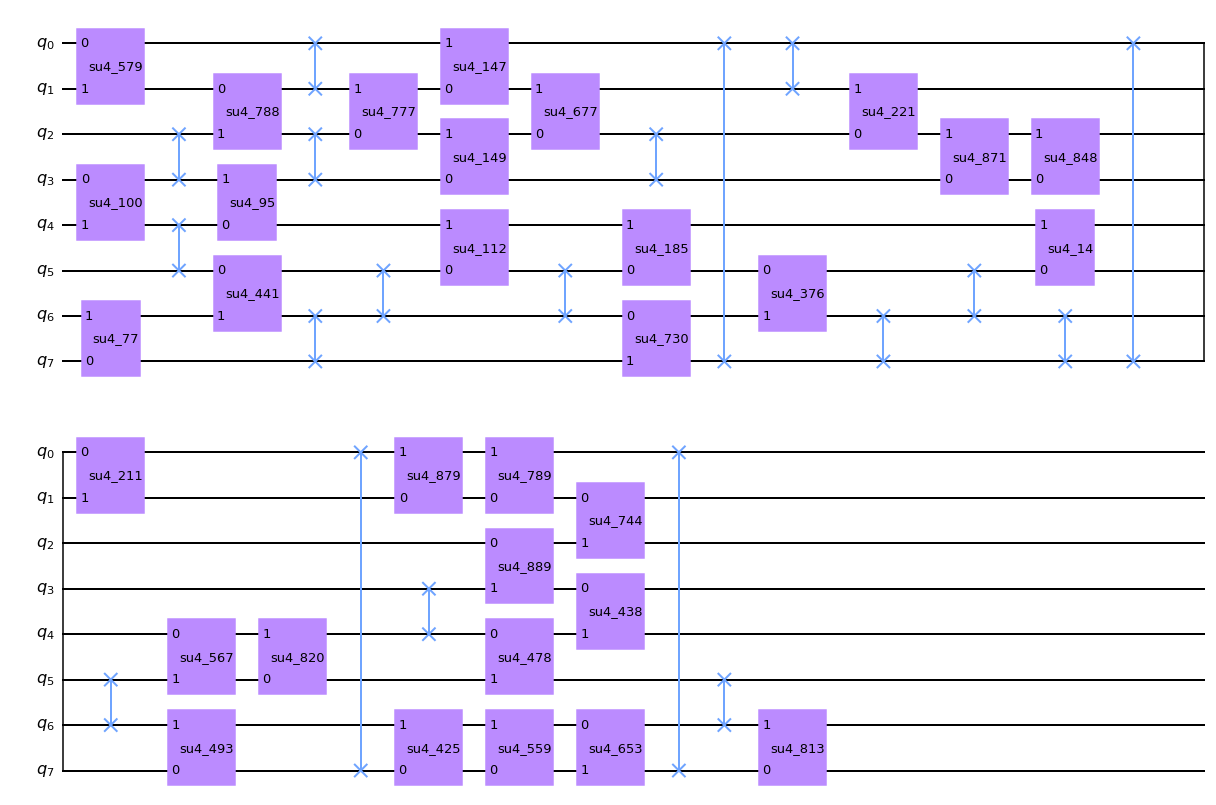

In [16]:
# *** SABRE Algorithm ***

def test_qiskit_swap(qc, swap_factory, cmap):
    dag = swap_factory(cmap).run(circuit_to_dag(qc))
    return dag_to_circuit(dag)

qc2 = test_qiskit_swap(dag_to_circuit(dag), partial(SabreSwap, heuristic='lookahead', seed=23894),
                       cmap=cmap)
qc2.draw('mpl')

In [17]:
# Circuit statistics for SABRE after a compiling with level 3 optimization.

transpile(qc2, basis_gates=['u3', 'cx'], optimization_level=3).count_ops()

2022-09-29 11:58:22,897 | INFO : Pass: UnitarySynthesis - 0.00000 (ms)
2022-09-29 11:58:22,899 | INFO : Pass: Unroll3qOrMore - 0.00000 (ms)
2022-09-29 11:58:22,900 | INFO : Pass: RemoveResetInZeroState - 0.00000 (ms)
2022-09-29 11:58:22,902 | INFO : Pass: OptimizeSwapBeforeMeasure - 0.00000 (ms)
2022-09-29 11:58:22,903 | INFO : Pass: RemoveDiagonalGatesBeforeMeasure - 0.00000 (ms)
2022-09-29 11:58:23,034 | INFO : Pass: UnitarySynthesis - 129.69184 (ms)
2022-09-29 11:58:23,036 | INFO : Pass: UnrollCustomDefinitions - 0.99373 (ms)
2022-09-29 11:58:23,037 | INFO : Begin BasisTranslator from source basis {('cx', 2), ('u3', 1), ('swap', 2)} to target basis {'snapshot', 'delay', 'reset', 'cx', 'u3', 'measure', 'barrier'}.
2022-09-29 11:58:23,040 | INFO : Basis translation path search completed in 0.002s.
2022-09-29 11:58:23,044 | INFO : Basis translation paths composed in 0.002s.
2022-09-29 11:58:23,046 | INFO : Basis translation instructions replaced in 0.003s.
2022-09-29 11:58:23,047 | INF

OrderedDict([('u3', 194), ('cx', 138)])

In [18]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

2022-09-29 12:00:55,898 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,900 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,901 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,902 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,904 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,905 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,906 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,908 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,909 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,909 | INFO : Total Assembly Time - 0.00000 (ms)
2022-09-29 12:00:55,910 | INFO : Total Assembly Time - 0.00000 (ms)
